In [1]:
!python -m venv my_env 

# Importing Libraries

In [2]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import string
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import ConfusionMatrixDisplay

# Data Preprocessing

In [3]:
df=pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")

In [4]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
df.groupby('status').describe()

Unnamed: 0                                       \
                          count          mean           std      min   
status                                                                 
Anxiety                  3888.0  33747.340535  17829.620748      0.0   
Bipolar                  2877.0  47813.527633   1930.643638  45394.0   
Depression              15404.0  25155.582316  12527.152951   6982.0   
Normal                  16351.0  24046.638554  16583.557735    733.0   
Personality disorder     1201.0  51254.000000    346.843144  50654.0   
Stress                   2669.0  37664.617834  10013.266598  27346.0   
Suicidal                10653.0  18325.178635   7448.871777   6985.0   

                                                            
                           25%      50%       75%      max  
status                                                      
Anxiety               34147.75  35119.5  52070.25  53042.0  
Bipolar               46113.00  46832.0  49934.00  50653.0  
Depression            14771.50  22053.5  38844.25  48287.0  
Normal                 4820.50  30760.0  37371.50  45393.0  
Personality disorder  50954.00  51254.0  51554.00  51854.0  
Stress                28618.00  29893.0  48801.00  49468.0  
Suicidal              12277.00  17692.0  23332.00  37657.0

In [6]:
print(df.dtypes)

Unnamed: 0     int64
statement     object
status        object
dtype: object


In [7]:
df['statement'] = df['statement'].astype(str)

## Cleaning

We'll remove all punctuation and special characters, and also We'll clean the text by removing all punctuation and special characters, and then converting it to lowercase. This will help ensure that the model focuses on the core words and phrases without being distracted by irrelevant formatting.convert the text to lowercase if any. 

In [8]:
def clean_text(text):
    """Removes all punctuation and special characters, converts text to lowercase."""
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    return text.lower() 

df['cleaned_statement'] = df['statement'].apply(clean_text)

## Label Encoding

In [9]:
le = LabelEncoder()
df['status_encoded'] = le.fit_transform(df['status'])

for i, status in enumerate(le.classes_):
    print(f"{status}: {i}")

Anxiety: 0
Bipolar: 1
Depression: 2
Normal: 3
Personality disorder: 4
Stress: 5
Suicidal: 6


## Analyse

As evident below, the dataset is imbalanced, meaning the classes are unevenly distributed. This can lead to biased models that perform poorly on the minority class.

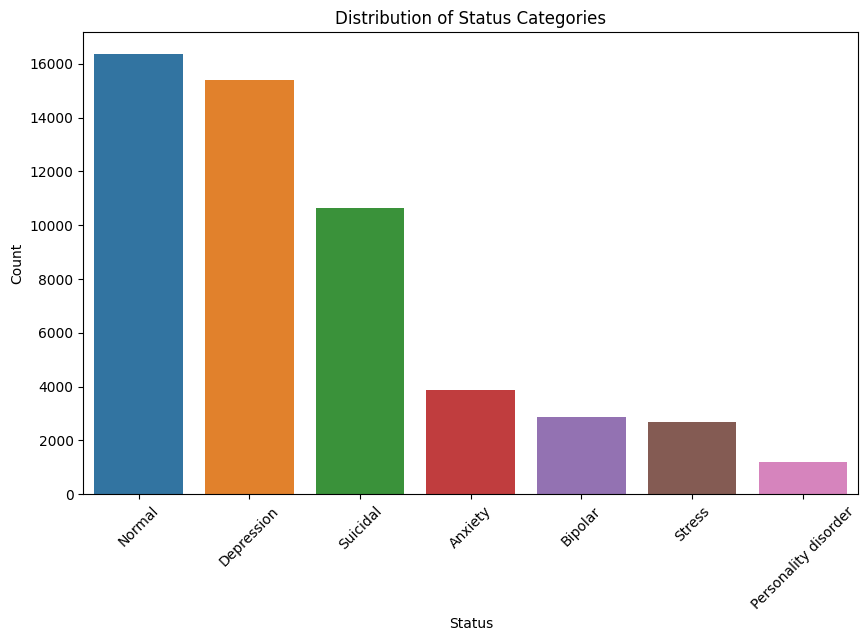

In [10]:
status_counts = df['status'].value_counts()

plt.figure(figsize=(10, 6)) 
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Status Categories')
plt.xticks(rotation=45)
plt.show()

In [11]:
df.sample(5)

,Unnamed: 0,statement,status,cleaned_statement,status_encoded
33322,33322,"well, you'll have hot fresh food tomorrow night.",Normal,well youll have hot fresh food tomorrow night,3
45785,45785,Afraid of being a hypochondriac The title says...,Bipolar,afraid of being a hypochondriac the title says...,1
47132,47132,Something I don't hear talked about a lot is h...,Depression,something i dont hear talked about a lot is ho...,2
27235,27235,Anyone here? I am on Lerivon..4th day..15mg..m...,Suicidal,anyone here i am on lerivon4th day15mgmy thoug...,6
14914,14914,"Things have not gotten better, I have only got...",Suicidal,things have not gotten better i have only gott...,6


In [12]:
df.dropna(inplace=True)
df.isnull().sum()

Unnamed: 0           0
statement            0
status               0
cleaned_statement    0
status_encoded       0
dtype: int64

In [13]:
X = df['cleaned_statement']
y = df['status_encoded']

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

#print(X_train1.shape,X_val1.shape,X_test.shape, y_train1.shape, y_val1.shape,y_test.shape)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape,y_test.shape)

(37130,) (15913,) (37130,) (15913,)


## Resampling

To address the imbalance issue, we'll combine oversampling and undersampling techniques. This approach will help ensure that the dataset retains its essential characteristics while improving the representation of all classes, leading to a more balanced and effective model.

In [16]:
data = pd.DataFrame({'x_train': X_train, 'y_train': y_train})
grouped_data = data.groupby('y_train')

desired_counts = {
    0: 5000,
    1: 3500,
    2: 10495,
    3: 11000,
    4: 2000,
    5: 3500,
    6: 8000
}

resampled_data = pd.concat([
    grouped_data.get_group(i).sample(n=desired_counts[i], replace=True)
    for i in desired_counts.keys()
])

balanced_x_train = resampled_data['x_train']
balanced_y_train = resampled_data['y_train']

print(balanced_y_train.value_counts())

y_train
3    11000
2    10495
6     8000
0     5000
1     3500
5     3500
4     2000
Name: count, dtype: int64


In [17]:
!pip install tensorflow==2.15.0 tensorflow-text==2.15.0 tensorflow-hub==0.16.1 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-decision-forests 1.9.1 requires tf-keras~=2.16, but you have tf-keras 2.15.1 which is incompatible.
tensorflow-serving-api 2.16.1 requires tensorflow<3,>=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.64 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


In [18]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Input

2024-09-16 18:16:47.939452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 18:16:47.939509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 18:16:47.940908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

# Model Building

We'll start by extracting contextual information with BERT, followed by using GRU and dense layers for classification.

In [20]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

sequence_output = outputs['sequence_output']


gru = tf.keras.layers.GRU(128, return_sequences=False)(sequence_output)
dropout1 = tf.keras.layers.Dropout(0.3)(gru)
dense1 = tf.keras.layers.Dense(64, activation='relu')(dropout1) 
x = tf.keras.layers.Dense(7, activation='softmax')(dense1) 

model = tf.keras.Model(inputs=[text_input], outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(balanced_x_train,
          balanced_y_train,
          epochs=5,
          batch_size=64  )

Epoch 1/5


I0000 00:00:1726510645.128567      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


680/680 [==============================] - 480s 688ms/step - loss: 0.8583 - accuracy: 0.6651
Epoch 2/5
680/680 [==============================] - 472s 694ms/step - loss: 0.5204 - accuracy: 0.7975
Epoch 3/5
680/680 [==============================] - 472s 694ms/step - loss: 0.3837 - accuracy: 0.8504
Epoch 4/5
680/680 [==============================] - 472s 694ms/step - loss: 0.2885 - accuracy: 0.8884
Epoch 5/5
680/680 [==============================] - 472s 694ms/step - loss: 0.2204 - accuracy: 0.9180


# Inference

In [22]:
y_pred_test = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

print("Classification Report (Test Set):\n", classification_report(y_test, y_pred_test_classes))

498/498 [==============================] - 160s 320ms/step
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.89      0.73      0.80      1157
           1       0.80      0.76      0.78       864
           2       0.69      0.79      0.74      4608
           3       0.92      0.94      0.93      4993
           4       0.59      0.69      0.64       370
           5       0.71      0.68      0.69       819
           6       0.70      0.58      0.63      3102

    accuracy                           0.78     15913
   macro avg       0.76      0.74      0.74     15913
weighted avg       0.78      0.78      0.78     15913



<Figure size 800x600 with 0 Axes>

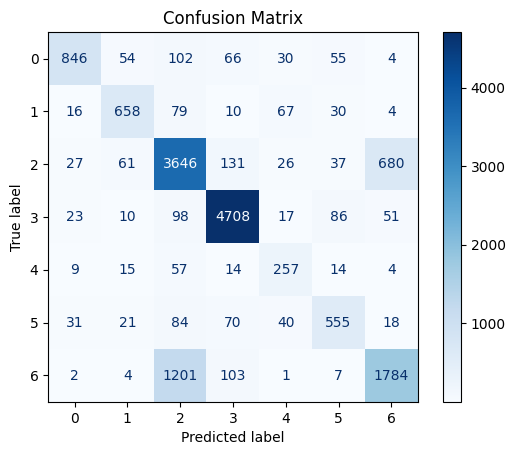

In [23]:
cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Conclusion

Overall the model got good accuracy.

But the performance on training was much higher than the test set, suggesting overfitting. To fix this, I'll try different things in further versions like adding more data for specific class using other techniques, changing number of layers, adding more dropout to stop it from learning too much. 

I'll also look at the confusion matrix to see which types of data the model is getting wrong and try to fix that. These changes will be included in the next version of the model.

# Done :)